In [1]:
import pickle

pickle_file = '-catsdogs.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    X_train = save['X_train']
    y_train = save['y_train']
    X_test = save['X_test']
    y_test = save['y_test']
    del save  # hint to help gc free up memory
    print('Training set', X_train.shape, y_train.shape)
    print('Test set', X_test.shape, y_test.shape)

('Training set', (14000, 64, 64), (14000, 1))
('Test set', (6000, 64, 64), (6000, 1))


In [2]:
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import backend as K

from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
# number of classes
num_classes = 2

# image dimensions
img_rows, img_cols = X_train.shape[1],  X_train.shape[2]

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

print input_shape

(1, 64, 64)


In [4]:
# model hyperparameters
batch_size = 16
nb_epoch = 30

# network architecture
patch_size_1 = 9
patch_size_2 = 5
patch_size_3 = 3
# patch_size_4 = 3

depth_1 = 128
depth_2 = 256
depth_3 = 512
# depth_4 = 1024

pool_size = 2

# num_hidden_1 = 512
# num_hidden_2 = 1028

# dropout = 0.5

In [5]:
model = Sequential()

model.add(Convolution2D(depth_1, patch_size_1, patch_size_1, border_mode='valid',
                        input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(depth_2, patch_size_2, patch_size_2, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(depth_3, patch_size_3, patch_size_3, border_mode='valid'))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

# model.add(Convolution2D(depth_4, patch_size_4, patch_size_4, border_mode='valid'))
# model.add(Activation('relu'))

model.add(AveragePooling2D(pool_size=(10, 10)))
model.add(Flatten())
model.add(Dense(num_classes))

model.add(Activation('softmax'))

In [6]:
filename = "-model-CAM.hdf5"
model.load_weights(filename)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [7]:
def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input], [model.layers[layer].output])
    activations = get_activations([X_batch,0])
    return activations

category: 1
prediction: 1


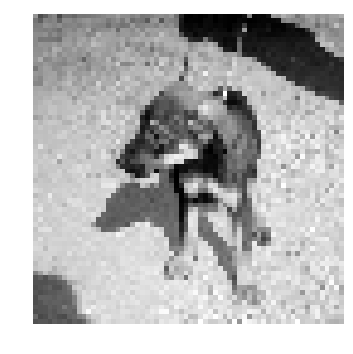

(1, 1, 64, 64)
(512, 10, 10)


In [12]:
%matplotlib inline

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

img_num = 13

X_t = X_train[img_num:img_num+1]

img = X_t[0][0]

category = np.argmax(Y_train[img_num])
print "category:", category
print "prediction:", np.argmax(model.predict(X_t)[0])

mi, ma = np.min(img), np.max(img)
imshow(img, cmap = plt.get_cmap('gray'), vmin = mi, vmax = ma,  interpolation='nearest')
plt.axis('off')
plt.show()

print X_t.shape

my_featuremaps = get_activations(model, 7, X_t)

maps = my_featuremaps[0][0]
print maps.shape

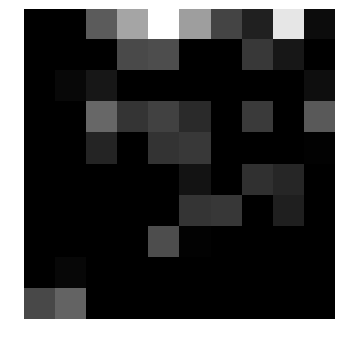

In [13]:
lay = maps[4]

mi, ma = np.min(lay), np.max(lay)
imshow(lay, cmap = plt.get_cmap('gray'), vmin = mi, vmax = ma,  interpolation='nearest')
plt.axis('off')
plt.show()

In [14]:
layer = model.layers[10]

print layer.input_shape
print layer.output_shape

(None, 512)
(None, 2)


(512, 2)


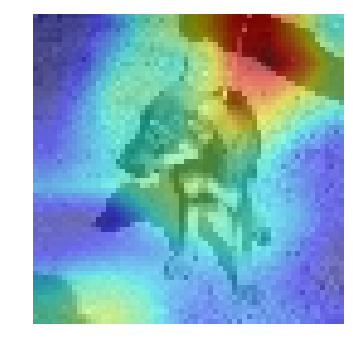

In [15]:
import scipy.misc

wts = layer.get_weights()
wts = wts[0]
print wts.shape

res = np.zeros((10,10))

for i in range(wts.shape[0]):
    m = maps[i]
    w = wts[i][category]
    r = np.multiply(m, w)
    res = res + r

mi, ma = np.min(img), np.max(img)
imshow(img, vmin = mi, vmax = ma, cmap = plt.get_cmap('gray'), interpolation='nearest')

plt.hold(True)

heatmap = scipy.misc.imresize(res, (64,64), interp='bilinear')
# heatmap = scipy.misc.imresize(res, (64,64), interp='nearest')

mi, ma = np.min(heatmap), np.max(heatmap)
imshow(heatmap, vmin = mi, vmax = ma, alpha=.5, interpolation='nearest')
plt.axis('off')
plt.show()